In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
df = sns.load_dataset('iris')

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Marginal Hexplot
- display correlation of two features
- hexplot shoes density of corrolation

/Users/heymanjake/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning:

The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.

/Users/heymanjake/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning:

The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.



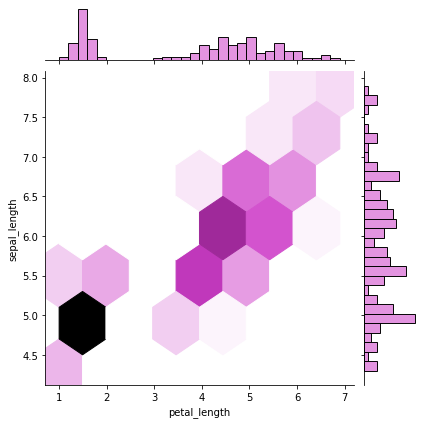

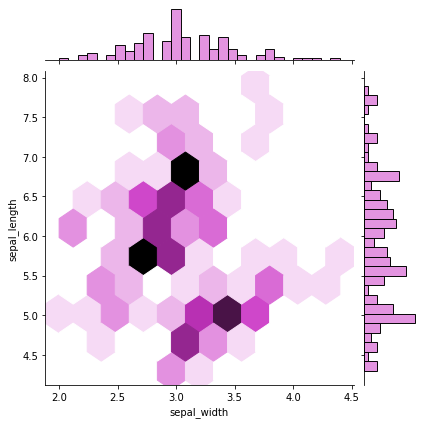

In [18]:
sns.jointplot(x=df["petal_length"], y=df["sepal_length"], color= 'orchid',
              kind='hex', marginal_kws=dict(bins=30, rug=True))
sns.jointplot(x=df["sepal_width"], y=df["sepal_length"], color= 'orchid',
              kind='hex', marginal_kws=dict(bins=30, rug=True))

# Jointgrid
- a more flexible joint plot that lets you select the bivariate plots

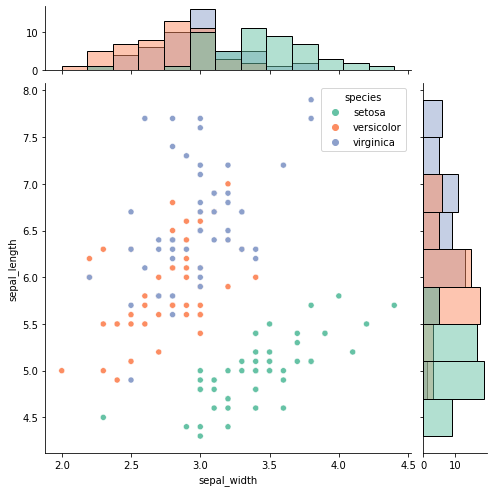

In [5]:
g = sns.JointGrid(data=df, x='sepal_width', y='sepal_length',
                  hue='species',palette='Set2',
                  height=7,marginal_ticks=True, )

g.plot(sns.scatterplot, sns.histplot)

# Distplot
- kernal density displot with target variables
- added a rugmap just for fun to see the individual occurances of instances in the data

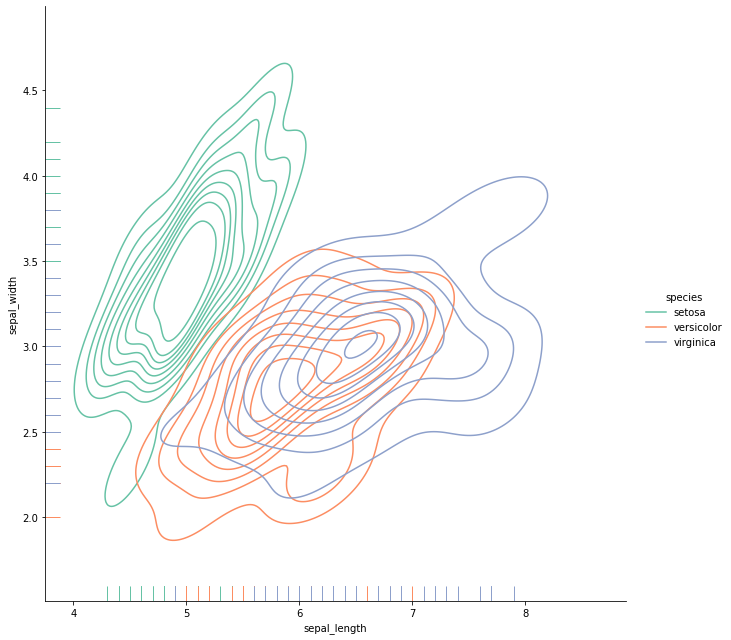

In [6]:
sns.displot(data=df,
          x='sepal_length',hue='species',
          y='sepal_width',kind='kde',
            height=9,clip=(0,None),
           palette='Set2',rug=True)


# Clustermap
- hierarchical clustered heatmap with dendrogram
- I think this is more convoluted than a regular corrolative heatmap

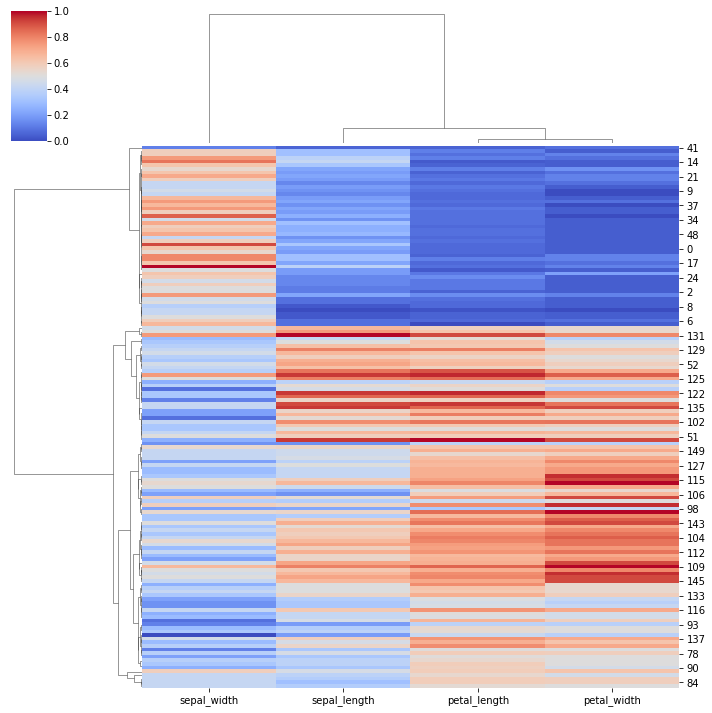

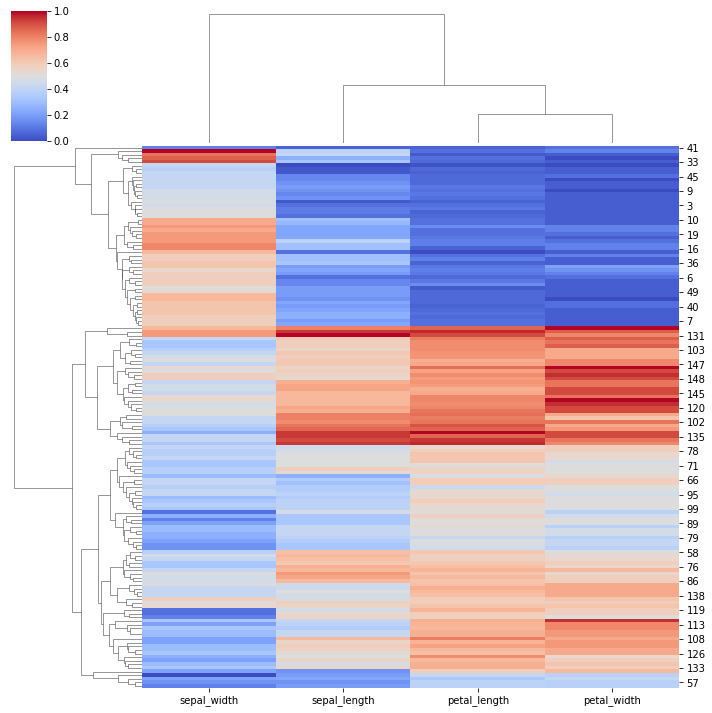

In [7]:
df1 = df.drop('species',axis=1)
sns.clustermap(df1, metric="correlation", standard_scale=1, cmap='coolwarm')

sns.clustermap(df1, metric="euclidean", standard_scale=1, cmap='coolwarm')

# Pairplot
- plot pairwise relationships
- markers changes the shape of the scatter dots
- fun way to see distribution of your target for all features

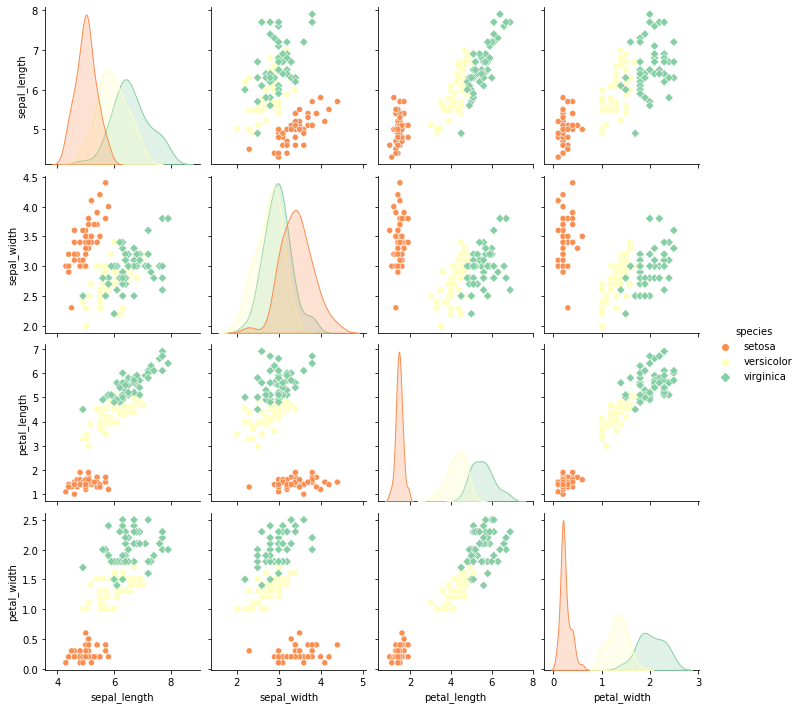

In [8]:
sns.pairplot(df, kind="scatter", hue="species",markers=["o", "s", "D"] , palette="Spectral")



# 2d PCA
- scatterplot of first two principal companants
- target variable is color labled


In [13]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=df['species'])
fig.show()

# 3D PCA scatterplot
- three dimensianal graph of principal components (cool way to show the dimensions of your data)
- color the target class and see the distribution of principal componants
- shows dimensianility of data

In [14]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=4)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['species'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

# LinaerRegression risidual plot


In [10]:
df = px.data.iris()

# Split data into training and test splits
train_idx, test_idx = train_test_split(df.index, test_size=.25, random_state=0)
df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'

X = df[['sepal_width', 'sepal_length']]
X_train = df.loc[train_idx, ['sepal_width', 'sepal_length']]
y_train = df.loc[train_idx, 'petal_width']

# Condition the model on sepal width and length, predict the petal width
model = LinearRegression()
model.fit(X_train, y_train)
df['prediction'] = model.predict(X)
df['residual'] = df['prediction'] - df['petal_width']

fig = px.scatter(
    df, x='prediction', y='residual',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.show()